In [1]:
# =======================
# 1. Install & Import
# =======================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

print("✅ All libraries imported successfully!")

2025-11-15 06:00:26.387315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763186426.595572      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763186426.649134      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ All libraries imported successfully!


In [2]:
# =======================
# 2. Dataset Paths (Kaggle Version)
# =======================
train_dir = "/kaggle/input/fishmargedataset/margeDataset/train"
val_dir   = "/kaggle/input/fishmargedataset/margeDataset/valid"
test_dir  = "/kaggle/input/fishmargedataset/margeDataset/test"

In [3]:
# =======================
# 3. Data Generators
# =======================
img_size = (224, 224)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())
print("✅ Found classes:", class_names)

Found 20597 images belonging to 20 classes.
Found 5885 images belonging to 20 classes.
Found 2943 images belonging to 20 classes.
✅ Found classes: ['Aair', 'Boal', 'Chapila', 'Foli', 'Ilish', 'KalBaush', 'Katla', 'Koi', 'Magur', 'Mrigel', 'Pabda', 'Pangas', 'Puti', 'Rui', 'Shol', 'SorPuti', 'Taki', 'Tarabaim', 'Telapiya', 'Tengra']


In [4]:
# =======================
#  Show Image Counts (Before & After Augmentation)
# =======================

def count_images_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                count += 1
    return count

train_count_before = count_images_in_dir(train_dir)
val_count_before   = count_images_in_dir(val_dir)
test_count_before  = count_images_in_dir(test_dir)

print("\n===============================")
print("📸 IMAGE COUNT SUMMARY")
print("===============================")
print(f"Original Training images:   {train_count_before}")
print(f"Original Validation images: {val_count_before}")
print(f"Original Testing images:    {test_count_before}")
print("----After Augmentation-------")
print(f"Train Generator samples:    {train_gen.samples}")
print(f"Val Generator samples:      {val_gen.samples}")
print(f"Test Generator samples:     {test_gen.samples}")


📸 IMAGE COUNT SUMMARY
Original Training images:   20597
Original Validation images: 5885
Original Testing images:    2943
----After Augmentation-------
Train Generator samples:    20597
Val Generator samples:      5885
Test Generator samples:     2943


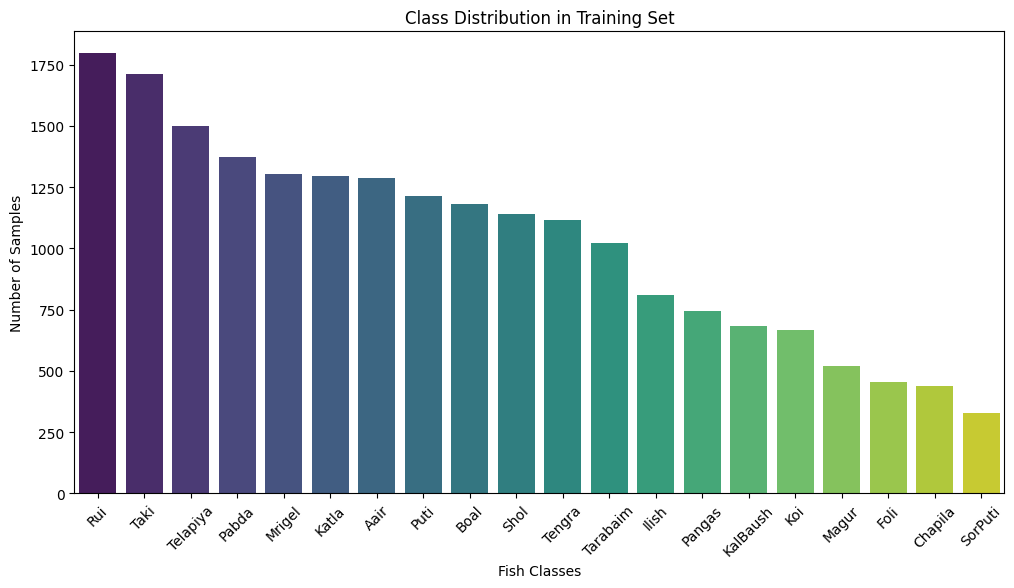

In [5]:
# =======================
# 4. Plot Class Distribution (Training set)
# =======================
labels = []
for c in class_names:
    class_path = os.path.join(train_dir, c)
    imgs = os.listdir(class_path)
    labels.extend([c]*len(imgs))

label_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Fish Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.show()

In [6]:
# =======================
# 5. Directory & Paths Setup (Kaggle paths)
# =======================
base_dir = "/kaggle/working/inceptionv3"
os.makedirs(base_dir, exist_ok=True)

model_path = os.path.join(base_dir, "inceptionv3_best.h5")
final_model_path = os.path.join(base_dir, "inceptionv3_final.h5")
log_path = os.path.join(base_dir, "inceptionv3_training_log.csv")

In [7]:
# =======================
# 6. Build or Load Model
# =======================
if os.path.exists(model_path):
    print("🔹 Loading previous best model...")
    model = load_model(model_path)
else:
    print("🔹 Building new InceptionV3 model...")

    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

model.summary()

🔹 Building new InceptionV3 model...


I0000 00:00:1763186456.258286      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,332,468 (85.19 MB)

 Trainable params: 529,684 (2.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [8]:
# =======================
# 7. Callbacks
# =======================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
csv_logger = CSVLogger(log_path, append=True)
checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [9]:
# =======================
# 8. Train Model (Phase 1: Frozen Base)
# =======================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs= 25,
    callbacks=[early_stop, csv_logger, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1763186475.190847     121 service.cc:148] XLA service 0x7a5b34003dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763186475.191870     121 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763186477.206026     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/322 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.0547 - loss: 3.7763   

I0000 00:00:1763186484.995701     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2980 - loss: 2.3876
Epoch 1: val_loss improved from inf to 0.99578, saving model to /kaggle/working/inceptionv3/inceptionv3_best.h5
322/322 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.2984 - loss: 2.3859 - val_accuracy: 0.7247 - val_loss: 0.9958
Epoch 2/25
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.6603 - loss: 1.1140
Epoch 2: val_loss improved from 0.99578 to 0.68722, saving model to /kaggle/working/inceptionv3/inceptionv3_best.h5
322/322 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.6604 - loss: 1.1138 - val_accuracy: 0.8080 - val_loss: 0.6872
Epoch 3/25
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.7429 - loss: 0.8375
Epoch 3: val_loss improved from 0.68722 to 0.55581, saving model to /kaggle/working/inceptionv3/inceptionv3_best.h5
322/322 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.7430 - loss: 0.8374 - val_accuracy: 0.8369 - val_loss: 0.5558
Epoch 4/25
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/ste

In [10]:
# =======================
# 9. Fine-Tune Model (Phase 2: Unfreeze top layers)
# =======================
print("🔹 Fine-tuning last 50 layers of InceptionV3...")
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, csv_logger, checkpoint]
)

🔹 Fine-tuning last 50 layers of InceptionV3...
Epoch 1/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.8788 - loss: 0.4928
Epoch 1: val_loss did not improve from 0.15102
322/322 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.8789 - loss: 0.4925 - val_accuracy: 0.9511 - val_loss: 0.1887
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.9220 - loss: 0.2667
Epoch 2: val_loss improved from 0.15102 to 0.14476, saving model to /kaggle/working/inceptionv3/inceptionv3_best.h5
322/322 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.9220 - loss: 0.2666 - val_accuracy: 0.9606 - val_loss: 0.1448
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.9416 - loss: 0.2012
Epoch 3: val_loss improved from 0.14476 to 0.11960, saving model to /kaggle/working/inceptionv3/inceptionv3_best.h5
322/322 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.9416 - loss: 0.2012 - val_accuracy: 0.9672 - val_loss: 0.1196
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - 

In [11]:
# =======================
# 10. Save Final Model
# =======================
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

✅ Final model saved to: /kaggle/working/inceptionv3/inceptionv3_final.h5


In [12]:
# =======================
# 11. Evaluate on Test Data
# =======================
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\n✅ Testing Accuracy : {test_acc*100:.2f}%")
print(f"✅ Testing Loss     : {test_loss:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 910ms/step - accuracy: 0.9768 - loss: 0.0742

✅ Testing Accuracy : 97.96%
✅ Testing Loss     : 0.0670


In [13]:
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"\n✅ Validation Accuracy : {val_acc*100:.2f}%")
print(f"✅ Validation Loss     : {val_loss:.4f}")

92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 365ms/step - accuracy: 0.9821 - loss: 0.0575

✅ Validation Accuracy : 98.30%
✅ Validation Loss     : 0.0575


In [15]:
train_loss,train_acc = model.evaluate(train_gen, verbose=1)
print(f"\n✅ train Accuracy : {train_acc*100:.2f}%")
print(f"✅ train Loss     : {train_loss:.4f}")

322/322 ━━━━━━━━━━━━━━━━━━━━ 298s 927ms/step - accuracy: 0.9906 - loss: 0.0382

✅ train Accuracy : 99.05%
✅ train Loss     : 0.0380


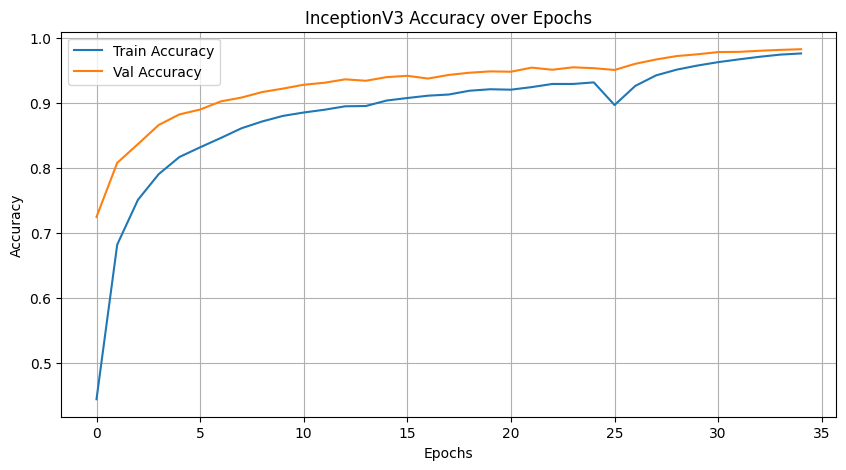

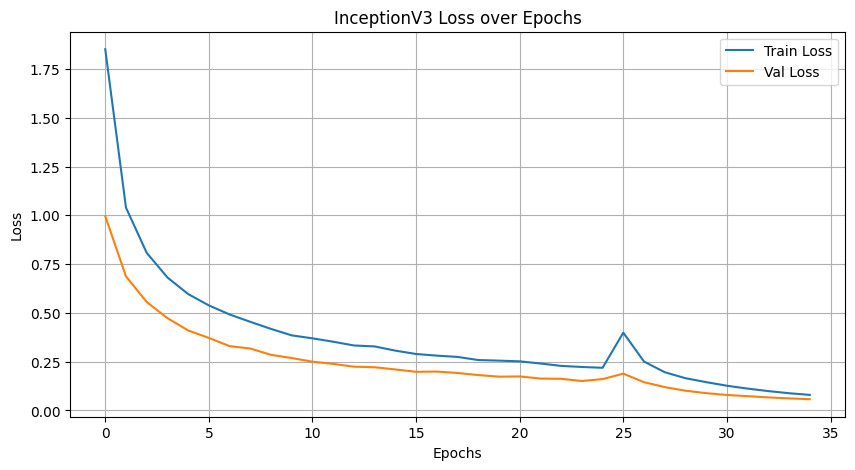

In [16]:
# =======================
# 12. Plot Training History
# =======================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('InceptionV3 Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('InceptionV3 Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# =======================
# 13. Predictions & Evaluation
# =======================
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("\n Classification Report:\n")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    digits=4
))

46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 572ms/step

 Classification Report:

              precision    recall  f1-score   support

        Aair     0.9945    0.9783    0.9863       184
        Boal     0.9880    0.9763    0.9821       169
     Chapila     0.9833    0.9516    0.9672        62
        Foli     0.9118    0.9538    0.9323        65
       Ilish     0.9823    0.9569    0.9694       116
    KalBaush     0.9792    0.9592    0.9691        98
       Katla     0.9785    0.9838    0.9811       185
         Koi     1.0000    0.9895    0.9947        95
       Magur     1.0000    1.0000    1.0000        74
      Mrigel     0.9579    0.9785    0.9681       186
       Pabda     0.9512    0.9949    0.9726       196
      Pangas     0.9813    0.9813    0.9813       107
        Puti     0.9886    1.0000    0.9943       174
         Rui     0.9727    0.9689    0.9708       257
        Shol     0.9817    0.9877    0.9847       163
     SorPuti     0.9400    1.0000    0.9691        47
        Taki 

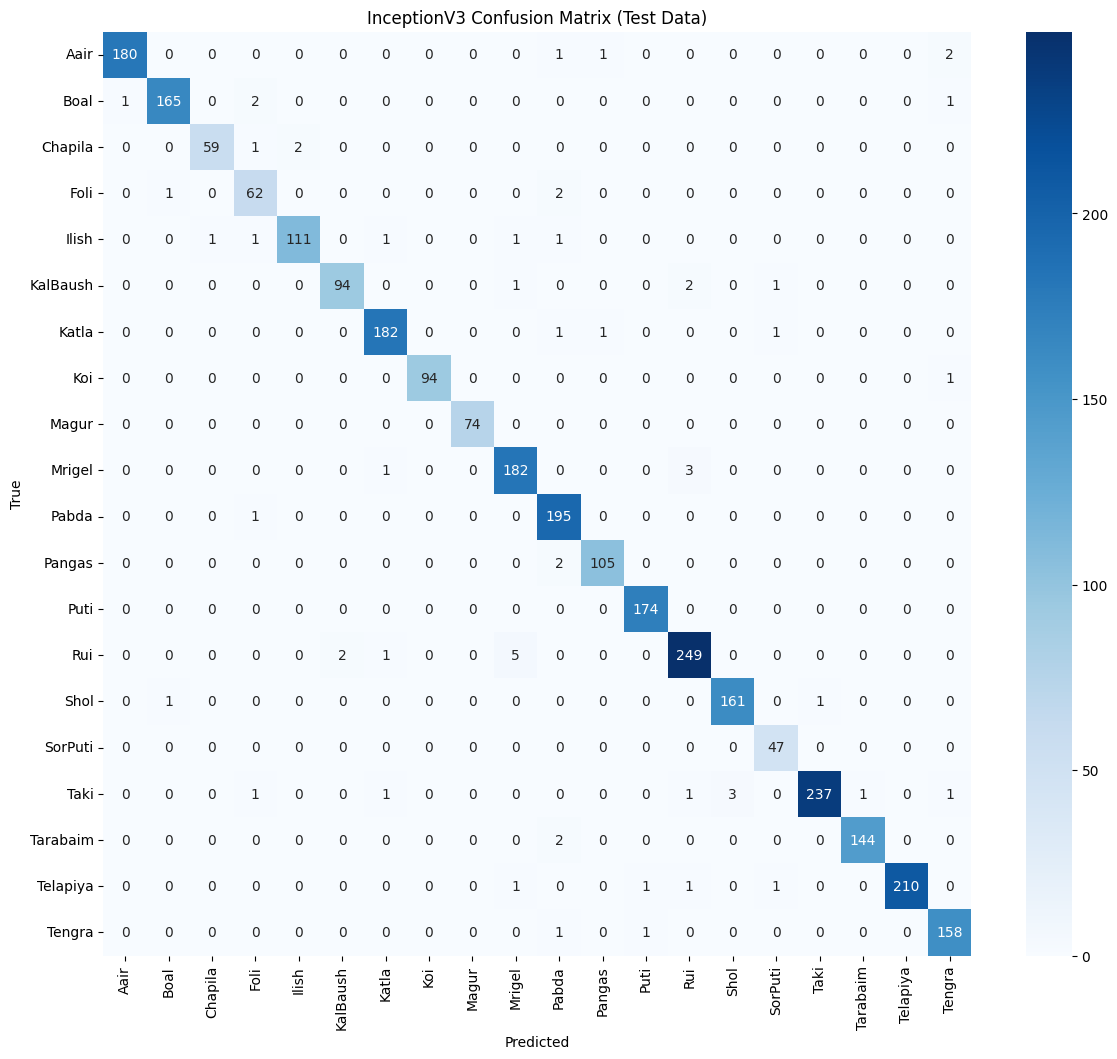

In [18]:
# =======================
# 14. Confusion Matrix
# =======================
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("InceptionV3 Confusion Matrix (Test Data)")
plt.show()


 Per-Class Metrics:

          Precision  Recall  F1-Score
Class                                
Aair         0.9945  0.9783    0.9863
Boal         0.9880  0.9763    0.9821
Chapila      0.9833  0.9516    0.9672
Foli         0.9118  0.9538    0.9323
Ilish        0.9823  0.9569    0.9694
KalBaush     0.9792  0.9592    0.9691
Katla        0.9785  0.9838    0.9811
Koi          1.0000  0.9895    0.9947
Magur        1.0000  1.0000    1.0000
Mrigel       0.9579  0.9785    0.9681
Pabda        0.9512  0.9949    0.9726
Pangas       0.9813  0.9813    0.9813
Puti         0.9886  1.0000    0.9943
Rui          0.9727  0.9689    0.9708
Shol         0.9817  0.9877    0.9847
SorPuti      0.9400  1.0000    0.9691
Taki         0.9958  0.9673    0.9814
Tarabaim     0.9931  0.9863    0.9897
Telapiya     1.0000  0.9813    0.9906
Tengra       0.9693  0.9875    0.9783


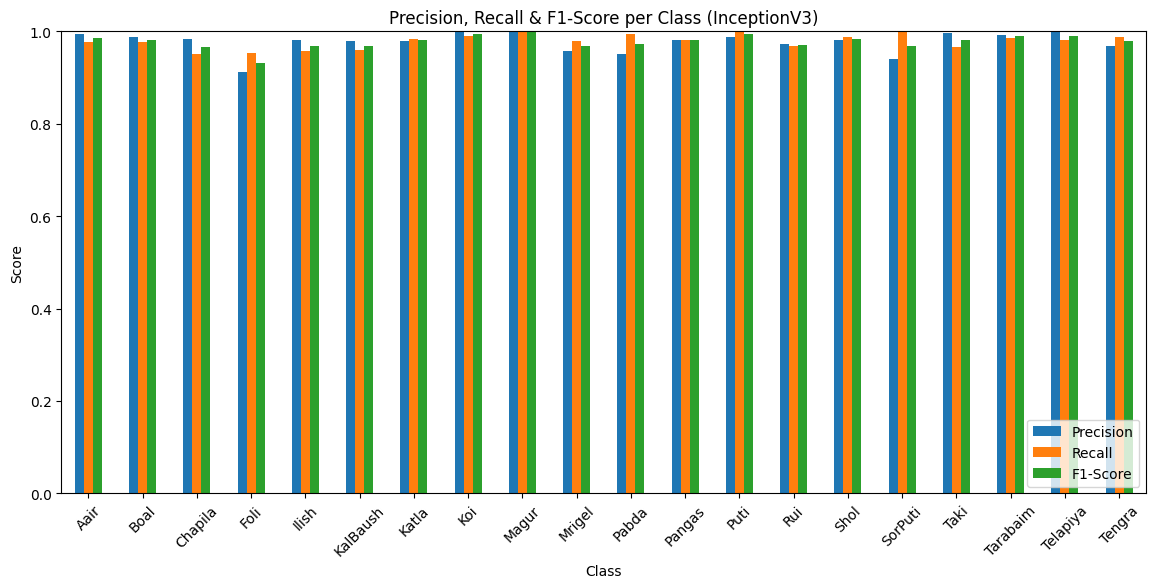

In [19]:
# =======================
# 15. Precision, Recall, F1 per Class
# =======================
precision = precision_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))
recall    = recall_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))
f1        = f1_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}).set_index('Class')

print("\n Per-Class Metrics:\n")
print(metrics_df.round(4))

metrics_df.plot(kind='bar', figsize=(14,6))
plt.title("Precision, Recall & F1-Score per Class (InceptionV3)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


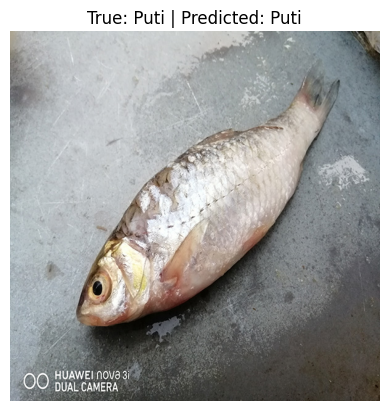

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


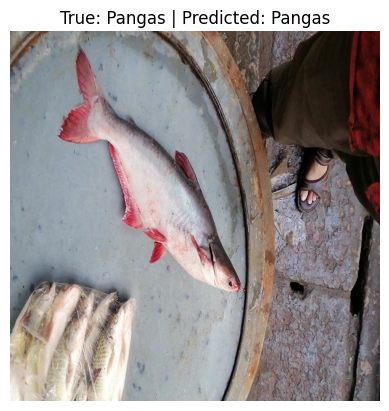

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


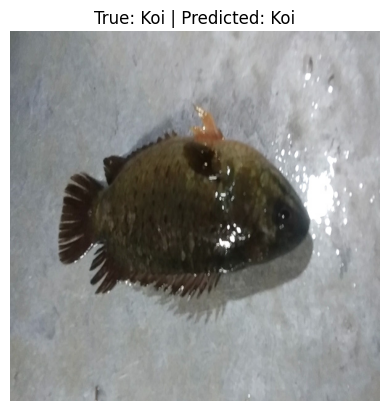

In [20]:
# =======================
# 16. Predict Random Test Images
# =======================
def predict_random_image(test_dir, model, class_names, img_size=(224,224)):
    random_class = random.choice(os.listdir(test_dir))
    class_path = os.path.join(test_dir, random_class)
    random_img = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, random_img)

    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]
    true_class = random_class

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis("off")
    plt.title(f"True: {true_class} | Predicted: {pred_class}")
    plt.show()

for i in range(3):
    predict_random_image(test_dir, model, class_names)